In [1]:
from numpy import *
from skimage import io, color

#random.seed(0)
#im = random.randint(0, 255, [1000, 1000], dtype=int)
imrgb = io.imread('img.png')
imrgb = imrgb[200:220,400:420,:]
im = color.rgb2gray(imrgb)

def get_L(imrgb):
    imlab = color.rgb2lab(imrgb)
    imlab[:,:,0] = imlab[:,:,0]*0.3
    im = color.rgb2gray(imrgb)
    ind_mat = arange(0,prod(im.shape), dtype=int).reshape(im.shape)

    pairs_mat = zeros(append(im.shape, 8), dtype=int)
    pairs_mat[:,:,0] = roll(ind_mat, 1, axis=0)
    pairs_mat[:,:,1] = roll(ind_mat, -1, axis=0)
    pairs_mat[:,:,2] = roll(ind_mat, 1, axis=1)
    pairs_mat[:,:,3] = roll(ind_mat, -1, axis=1)
    pairs_mat[:,:,4] = roll(roll(ind_mat, 1, axis=0), 1 , axis=1)
    pairs_mat[:,:,5] = roll(roll(ind_mat, 1, axis=0), -1, axis=1)
    pairs_mat[:,:,6] = roll(roll(ind_mat, -1, axis=0), 1, axis=1)
    pairs_mat[:,:,7] = roll(roll(ind_mat, -1, axis=0), -1, axis=1)

    pairs1 = pairs_mat.flatten().reshape(1,8*prod(im.shape))
    pairs2 = repeat(ind_mat[:,:, newaxis], 8, axis=2).flatten().reshape(1,8*prod(im.shape))
    pairs = append(pairs2, pairs1, axis=0).transpose()
    pairs_u = sort(pairs, axis=1)
    pairs_u = unique(pairs_u, axis=0)

    M = zeros([8, prod(im.shape)])
    for pair in pairs_u:
        for k in range(8):
            if M[k, pair[0]] == 0:
                temp =  exp(linalg.norm(imlab[unravel_index(pair[0], tuple(im.shape))]-imlab[unravel_index(pair[1], tuple(im.shape))])/-2.0)
                M[k, pair[0]] = temp.copy()
                M[k, pair[1]] = (-1*temp).copy()
    L = asfarray([M, zeros(M.shape), zeros(M.shape), zeros(M.shape), M, zeros(M.shape), zeros(M.shape), zeros(M.shape), M]).reshape((3*M.shape[0], 3*M.shape[1])) 
    return L

In [2]:
L = get_L(imrgb)

In [3]:
c0 = 20.0 #alpha
c1 = 120.0 #lambda
c2 = 50.0 #theta
pixel_num = prod(im.shape)
target = transpose(asfarray([imrgb[:,:,0].flatten(), imrgb[:,:,1].flatten(), imrgb[:,:,2].flatten()])).flatten()

#from scipy import sparse
#L_s = sparse.csr_matrix(L) 

In [4]:
L= c0 * L
left_hand = c1*dot(transpose(L), L) + c2*identity(L.shape[1])

In [5]:
ref = zeros((pixel_num*3,1))
old_ref = target.copy()
b_1 = zeros([L.shape[0],1])
d_1 = zeros([L.shape[0],1])

In [6]:
def shrink(v, lam):
    index = (v<0).ravel().nonzero();
    d = maximum(abs(v) - lam, 0);
    d[index] = -1 * d[index];
    return d

itr_num = 5
for i in range(itr_num):
    old_ref = ref;
    right_hand = c2*target.reshape([target.shape[0], 1]) + c1*(dot(transpose(L),(d_1 - b_1)))

    ref = linalg.solve(left_hand, right_hand)
    temp_1 = dot(L,ref)
    d_1 = shrink(temp_1 + b_1, (1.0/c1))
    b_1 = b_1 + temp_1 - d_1 
                 

In [7]:
flat_image = uint8(ref).reshape(imrgb.shape)

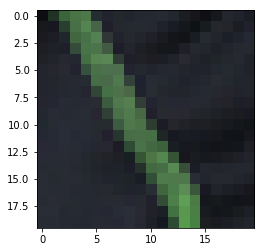

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(imrgb)
plt.show()

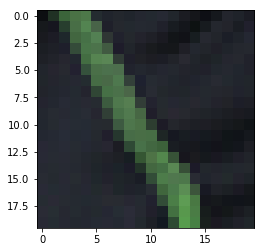

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(flat_image)
plt.show()